/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with val loss: 0.1207
Epoch 1/150, Train Loss: 0.1355, Val Loss: 0.1207
New best model saved at epoch 2 with val loss: 0.1176
Epoch 2/150, Train Loss: 0.1247, Val Loss: 0.1176
New best model saved at epoch 3 with val loss: 0.1136
Epoch 3/150, Train Loss: 0.1196, Val Loss: 0.1136
New best model saved at epoch 4 with val loss: 0.1109
Epoch 4/150, Train Loss: 0.1152, Val Loss: 0.1109
Epoch 5/150, Train Loss: 0.1126, Val Loss: 0.1116
New best model saved at epoch 6 with val loss: 0.1058
Epoch 6/150, Train Loss: 0.1109, Val Loss: 0.1058
Epoch 7/150, Train Loss: 0.1092, Val Loss: 0.1062
New best model saved at epoch 8 with val loss: 0.1002
Epoch 8/150, Train Loss: 0.1082, Val Loss: 0.1002
Epoch 9/150, Train Loss: 0.1069, Val Loss: 0.1007
Epoch 10/150, Train Loss: 0.1056, Val Loss: 0.1023
New best model saved at epoch 11 with val loss: 0.0972
Epoch 11/150, Train Loss: 0.1046, Val Loss: 0.0972
Epoch 12/150, Train Loss: 0.1042, Val Loss: 0.0973
New best model sav

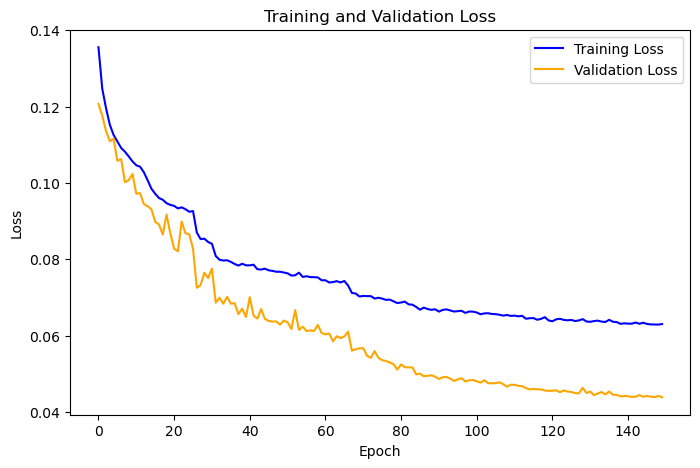

Test accuracy (with best model): 0.9402


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import sys
from maze_env import PolicyNetwork

# Select device: Apple MPS if available, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load preference dataset (two points per row: better vs worse)
df_preferences = pd.read_parquet("../tests/preferences.parquet")

# Split into train (90%), val (5%), test (5%)
train_df = df_preferences.sample(frac=0.90, random_state=42)
temp_df = df_preferences.drop(train_df.index)
val_df = temp_df.sample(frac=0.50, random_state=42)
test_df = temp_df.drop(val_df.index)


class PreferenceDataset(Dataset):
    """
    Dataset of pairwise preferences.
    Each item returns:
      - x_better: preferred state (normalized)
      - x_worse : non-preferred state (normalized)
      - label   : preference indicator (kept for completeness)
    """
    def __init__(self, df):
        # Load normalization statistics used during model training
        norm_stats_path = "../tests/norm_stats.npz"
        norm = np.load(norm_stats_path)
        mean = norm["mean"].astype(np.float32)
        std  = norm["std"].astype(np.float32) + 1e-8  # add epsilon for stability

        self.x_better = ((df[["x_better", "y_better"]].values - mean) / std).astype(np.float32)
        self.x_worse  = ((df[["x_worse",  "y_worse" ]].values - mean) / std).astype(np.float32)
        self.labels = df["preference"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x_better[idx], dtype=torch.float32),
            torch.tensor(self.x_worse[idx],  dtype=torch.float32),
            torch.tensor(self.labels[idx],   dtype=torch.float32),
        )


def dpo_loss(model, xb, xw, m=0.25):
    """
    Margin-based pairwise loss:
      loss = mean(max(0, m - (r(xb) - r(xw))))
    Encourages the model to score preferred states higher by at least margin m.
    """
    return torch.clamp(m - (model(xb) - model(xw)), min=0).mean()


# Training hyperparameters
batch_size = 128
epochs = 150
learning_rate = 1e-3
hidden_dim = 256
num_layers = 4
dropout_prob = 0.05

# Early stopping
early_stopping_patience = 10  # stop if no val improvement for this many epochs

# Build datasets and loaders
train_dataset = PreferenceDataset(train_df)
val_dataset   = PreferenceDataset(val_df)
test_dataset  = PreferenceDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Model, optimizer, scheduler
model = PolicyNetwork(
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout_prob=dropout_prob
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

best_val_loss = float('inf')
no_improvement_count = 0  # epochs without validation improvement

train_losses = []
val_losses = []

# ----------------
# Training loop
# ----------------
for epoch in range(epochs):
    # Train
    model.train()
    epoch_train_loss = 0.0
    for x_better, x_worse, _ in train_dataloader:
        x_better, x_worse = x_better.to(device), x_worse.to(device)
        optimizer.zero_grad()
        loss = dpo_loss(model, x_better, x_worse)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validate
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_better, x_worse, _ in val_dataloader:
            x_better, x_worse = x_better.to(device), x_worse.to(device)
            loss = dpo_loss(model, x_better, x_worse)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Scheduler step on validation loss
    scheduler.step(avg_val_loss)

    # Checkpoint best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_dpo_policy.pth")
        print(f"New best model saved at epoch {epoch+1} with val loss: {avg_val_loss:.4f}")
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

# -------------
# Plot losses
# -------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses,   label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ----------
# Testing
# ----------
# Load best checkpoint and evaluate pairwise accuracy on test set
model.load_state_dict(torch.load("best_dpo_policy.pth"))
model.to(device)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x_better, x_worse, _ in test_dataloader:
        x_better, x_worse = x_better.to(device), x_worse.to(device)
        r_better = model(x_better)
        r_worse  = model(x_worse)
        correct += torch.sum(r_better > r_worse).item()  # predicted preference matches label
        total   += x_better.size(0)

test_accuracy = correct / total
print(f"Test accuracy (with best model): {test_accuracy:.4f}")


In [2]:
states = torch.rand(256, 2, device=device)
with torch.no_grad():
    v = model(states).cpu().numpy().squeeze()
print("value range:", v.min(), v.max())


value range: -1.9788505 6.2813087
